# Variational Quantum Eigensolver

### Juan Luis Salas Montoro

### 24/03/2025

## Introduction

In this notebook, I present an implementation of the VQE algorithm applied to the $H_2$ molecule.

The variational quantum eigensolver (VQE) is a hybrid classical-quantum algorithm that variationally determines the ground state energy of a Hamiltonian.

The algorithm is divided in 5 parts:

* Write the hamiltonian in the computational basis.

* Obtain a variational ansatz to parameterize the wave function.

* Represent this ansatz as a quantum circuit.

* Given this circuit, measure the expectation value of Hamiltonian (energy).

* Minimize the energy depending on the circuit patameters.

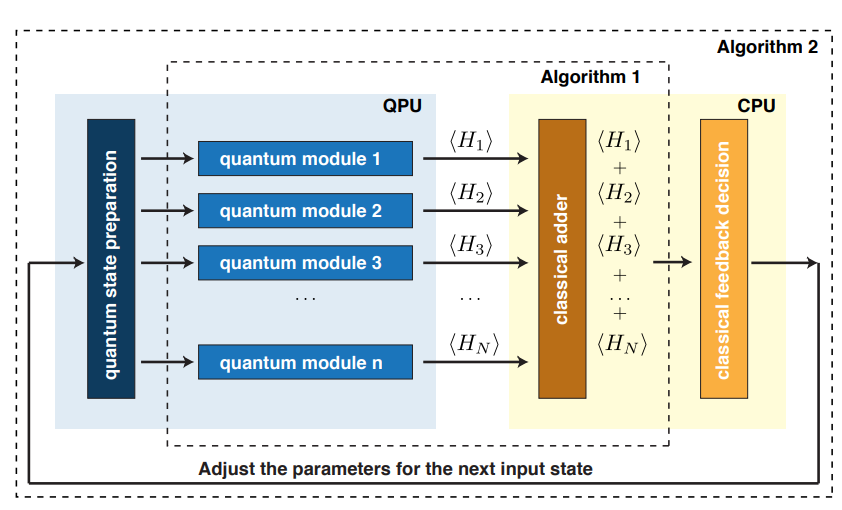

**Figure 1:** *Architecture of the VQE (in the original paper they used real quantum devices with parametrized states to calculate expectattion values and a classical CPU to compute the energy and minimization)* **[4]**.

## Writing the hamiltonian in computational basis

In order to work with the hamiltonian and calculate it expected value (energy) with qubits, we need to express it in computational basis. We start with the electronic hamiltonian of the molecule (in atomic units for simplicity):

$$\hat{H}=-\sum_{i=1}^{n_e}-\frac{\nabla_i^2}{2} - \sum_{i=1}^{n_e}\sum_{l=1}^{n_p}\frac{Z_l}{r_{il}} + \sum_{i=1, j>i}^{n_e} \frac{1}{r_{ij}} $$

Which takes into account, in order: the kinetic energy of the electrons, the electron-nuclei attraction and the electron-electron repulsion. The nuclei-nuclei interaction is not accounted in this hamiltonian since its energy aportation is constant given the nuclear separation parameter. This hamiltonian, second quantized, can be expresed with common quantum gates using the **Jordan-Wigner (JW)** transformation and the **Bravyi-Kitaev (BK)** transformation **[1]**.

According to **[2]**, the hamiltonian of the $H_2$ molecule, using **BK** trnasformations can be expressed with only two qubits:

$$ \hat{H}=g_0\hat{I} + g_1 \hat{Z_0} + g_2 \hat{Z_1} + g_3 \hat{Z_0}\hat{Z_1} + g_4 \hat{Y_0}\hat{Y_1} + g_5 \hat{X_0}\hat{X_1} $$

With the $g_i$ coefficients obtained from a Hartre-Fock calculation. Given these coefficients, we can calculate the expected value of the hamiltonian, the energy, as:

$$E = \langle \hat{H} \rangle = g_0 + g_1 \langle\hat{Z_0}\rangle + g_2 \langle\hat{Z_1}\rangle + g_3 \langle\hat{Z_0}\hat{Z_1}\rangle + g_4 \langle\hat{Y_0}\hat{Y_1}\rangle + g_5 \langle\hat{X_0}\hat{X_1}\rangle$$

Where $\langle \hat{I} \rangle = 1$. So instead of measuring the energy, we measure several times each operator and calculate it's expectation value.

We will use the data from **Table 1** of **[2]**, using an nuclear separation of $R=0.75\r{A}$ which is near the equilibrium point:
| Coefficient | Value |
| -------- | ------- |
| $g_0$ | $-0.4804$ |
| $g_1$ | $+0.3435$ |
| $g_2$ | $-0.4347$ |
| $g_3$ | $+0.5716$ |
| $g_4$ | $+0.0910$ |
| $g_5$ | $+0.0910$ |

Plus the nuclear repulsion energy term, which is $0.7055696146$

In [10]:
#=============== g coefficients ==================
g0 = -0.4804
g1 =  0.3435
g2 = -0.4347
g3 =  0.5716
g4 =  0.0910
g5 =  0.0910

#============ Nuclear repulsion energy =============
nuclear_repulsion = 0.7055696146 

This hamiltonian expectation value discussion is pointless unless we define a **wave function**, since we need it to calculate the expectation values. Nevertheless, we can make a first approach to get the energy by calculating the lowest eigenvalue of the hamiltonian with **classical algebra** diagonalization. That procedure can be easily done in this case where the dimension of the Hilbert space is 4. For more complex molecules the diagonalization becomes harder.

To compare our results, we will use the exact energy data from **[1]**:   $\quad E_{ground}=-1.1457416808$.

In [11]:
#============== I and Pauli operators =============

# Importing some packages
import numpy as np

# 1 qubit operators
I = np.array([[1, 0],
              [0, 1]])

X = np.array([[0, 1],
              [1, 0]])

Y = np.array([[0, -1j],
              [1j, 0]])

Z = np.array([[1, 0],
              [0, -1]])

# 2 qubits operators
II = np.kron(I, I)

Z0 = np.kron(Z, I)

Z1 = np.kron(I, Z)

ZZ = np.kron(Z, Z)

YY = np.kron(Y, Y)

XX = np.kron(X, X)

#============= Creating H matrix ===============

H = g0*II + g1*Z0 + g2*Z1 + g3*ZZ + g4*YY + g5*XX
print("Hamiltonian matrix:\n", H)

#======== Getting the lowest eigenvalue ========

E_elec_eigen = np.linalg.eigvalsh(H)[0]

# Add the nuclear repulsion to have the complete energy
E_ground_eigen = E_elec_eigen + nuclear_repulsion
print("\n==========================================================")
print("Energy from diagonalization:", E_ground_eigen)

#================ Exact energy ===============

E_ground_exact = -1.1457416808
print("Exact energy:", E_ground_exact)


Hamiltonian matrix:
 [[ 1.11022302e-16+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -2.73800000e-01+0.j  1.82000000e-01+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  1.82000000e-01+0.j -1.83020000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   1.82400000e-01+0.j]]

Energy from diagonalization: -1.1456295095236442
Exact energy: -1.1457416808


We can see that this first approach gives nice results, but the method employed in these calculations involves classical diagonalization instead of quantum computing. To address the problem with the expectation values, we need to define a wave function.

## Variational ansatz to parameterize the wave function

The variational calculation of the energy relies on the fact that (assuming normalized wave functions):

$$\langle \psi(\alpha) | \hat{H} | \psi(\alpha) \rangle \geq E_{ground}$$

Where $\psi(\alpha)$ is a **test wave function** that depends on any number of paramaters represented by $\alpha$. The idea is to **minimize the energy** by adjusting the parameters until the expectation value of the energy reaches $E_{ground} $. We call **ansatz** to  the unitary operator $\hat{U}(\alpha)$, later represented by a quantum circuit,  that applied to an initial state gives us the parameterized wave function.

As it is done in **[1]**, we will use the Unitary Coupled Cluster (UCC) ansatz from **[2]**, which depends only on one parameter, $\theta$:

$$\hat{U}(\theta)=e^{-i\theta\hat{X_0}\hat{Y_1}}$$

On the initial state $|01\rangle$. So the parameterized test wave function is:

$$\psi(\theta) = e^{-i\theta\hat{X_0}\hat{Y_1}}|01\rangle$$

Now, before implementing the ansatz as a quantum circuit, we can try a second approach to the energy calculation by minimizating the parameterized wavefunction depending on $\theta$.

In [12]:
# Importing useful resources
from scipy.optimize import minimize
from scipy.linalg import expm
import random


#=============== <H>(theta) function definition ================

def expected_energy(theta):

    # Defining ansatz operator as the exponential matrix
    ansatz_operator = expm(-1j*theta*np.kron(X,Y))
    

    # Using the initial state |01>
    init_state = np.array([0, 1, 0, 0])

    # Calculating the parameterized wavefunction |psi(theta)>
    psi = np.dot(ansatz_operator, init_state)

    # Return the result of: <psi(theta)|H|psi(theta)>
    return np.real(np.dot(psi.conj().T, np.dot(H, psi)))


# =========== Energy minimization ==================

# Random value of theta as initial guess
initial_theta = random.random()*2*np.pi

# Scipy minimization
minimization_result = minimize(expected_energy, initial_theta)

# Optimal value of parameter theta
opt_theta = minimization_result.x[0]
print("Optimal value of parameter theta:", opt_theta)

# Minimum value of energy from minimization
E_elec_minimiz = minimization_result.fun

# Adding the nuclear repulsion energy
E_ground_minimiz = E_elec_minimiz + nuclear_repulsion
print("Energy from minimization of the parameterized wavefunction:", E_ground_minimiz)

# Other energy result for comparison
print("\n============================== Other energy results ==============================")
print("Energy from diagonalization:", E_ground_eigen)
print("Exact energy:", E_ground_exact)

Optimal value of parameter theta: 4.597517119419731
Energy from minimization of the parameterized wavefunction: -1.1456295095236446

============================== Other energy results ==============================
Energy from diagonalization: -1.1456295095236442
Exact energy: -1.1457416808


## Represent ansatz as a quantum circuit

All the energy values obtained in the previous calculations are quite nice and very similar to the exact value we are taking as a reference. In the other hand, all of them rely on classical algebra to compute the expectation values. In this case, for the $H_2$ molecule, the dimension of the Hilbert space is small and the calculations are done quickly.

For more complex molecules we will need more qubits to represent the hamiltonian, increasing the dimension of the Hilbert space significantly. So the advantage of the VQE algorithm relies on **using a quantum circuit to implement the ansatz** (that advantadge is not appeciated in this notebook since we are emulating the quantum circuit in our classical device, an it will not be there until the algorithm is executed in real quantum devices).

As it is said in **[1]**, according to **[2]**, the UCC ansatz can be expressed as the following quantum circuit:

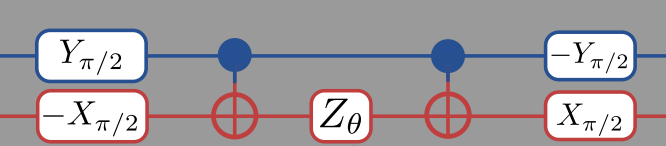

**Figure 2:** *Quantum circuit implementation of the UCC ansatz* **[2]**.

So let implement the circuit in Qiskit! First we need to create a 2 qubits circuit and prepare the initial state $|01\rangle$ by adding a $\hat{X}$ gate in the qubit 1.

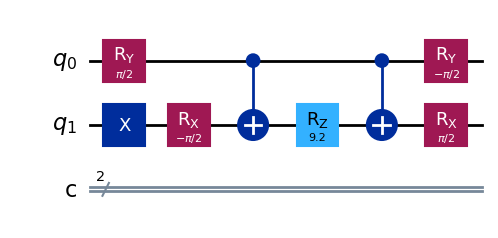

In [13]:
# Import resources from qiskit
from qiskit import QuantumCircuit

# ================== Circuit creation and initial state preparation==================

qc = QuantumCircuit(2, 2)

# |01> preparation
qc.x(1)

# ================== Function that appends the ansatz to circuit =================

def ansatz_circuit(circuit, theta):

    # Half rotation around Y axis
    circuit.ry(np.pi/2, 0) 
    # Half rotation around X axis
    circuit.rx(-np.pi/2, 1)

    # CNOT gate
    circuit.cx(0, 1)

    # Rotate 2theta rads around Z axis
    circuit.rz(2*theta, 1)

    # CNOT gate
    circuit.cx(0, 1)

    # Half rotation around Y axis
    circuit.ry(-np.pi/2, 0) 
    # Half rotation around X axis
    circuit.rx(np.pi/2, 1)

# ============= Circuit visualization =============

# We will use the theta value obtained before
ansatz_circuit(qc, opt_theta)

# Display the circuit
display(qc.draw("mpl"))


## Measure the expectation value of Hamiltonian

In order to calculate the expecatation value of the hamiltonian we need to measure and calculate the expectation value of different Pauli observables:

$$E = \langle \hat{H} \rangle = g_0 + g_1 \langle\hat{Z_0}\rangle + g_2 \langle\hat{Z_1}\rangle + g_3 \langle\hat{Z_0}\hat{Z_1}\rangle + g_4 \langle\hat{Y_0}\hat{Y_1}\rangle + g_5 \langle\hat{X_0}\hat{X_1}\rangle = \sum_i g_i \langle\hat{O_i}\rangle$$

In order to calculate every expectation value $\langle\hat{O_i}\rangle$, we will always measure the state in the computational basis. In this basis we use the $\hat{Z}$ operator which has the eigenvalues $1$ and $-1$ for the eigenvector $|0\rangle$ and $|1\rangle$ respectively. Since we are working with 2 qubits, we will measure both, so the basis used to measure is formed by the eigenvectors of $\hat{Z_0}\otimes\hat{Z_1}=\hat{Z_0}\hat{Z_1}$:

$$\hat{Z_0}\hat{Z_1} = \begin{pmatrix}
1 & 0 & 0 & 0\\
0 & -1 & 0 & 0\\
0 & 0 & -1 & 0\\
0 & 0 & 0 & 1
\end{pmatrix}$$

Whose eigenvalues and eigenvector are:
* $1$ for $|00\rangle$ and $|11\rangle$
* $-1$ for $|01\rangle$ and $|10\rangle$

So we can compute the expected value as the following: $\langle\hat{Z_0}\hat{Z_1}\rangle = P(|00\rangle)+P(|11\rangle)-P(|01\rangle)-P(|10\rangle)$, where $P(|x\rangle)$ can be calculated as the number of measurements with result $x$ divided by the total number of measurements.

In [ ]:
# ================================== Expetation value function ============================================

# Takes as input a dictionary with the simulation results and the number of measurments made
# Qiskit counts dictionary: {"result"" (key) : times_measured (value)}  Example: {"11" : 120, "00" : 350, "01" : 43}
def expect_value(counts, shots):

    # Aux variable to account the eigenvalues
    sum = 0

    # Loop all posible results
    for i in counts:

        # Eigenvectors with eigenvalue 1
        if i == "11" or i == "00":
            sum += counts[i]
        
        # Eigenvectors with eigenvalue -1
        else:
            sum -= counts[i]
    
    # Divide by the total measurements made
    return sum/shots


To make the measurements of the Pauli operators $\hat{X}$ and $\hat{Y}$ we should parse the vectors from the basis generated by its eigenvectors to the computational basis: $|0\rangle$ and $|1\rangle$.

Lets start with the eigenvectors of $\hat{X}$, wich are:
* Eigenvalue 1:$$|+\rangle=\frac{|0\rangle+|1\rangle}{\sqrt{2}}$$ 
* Eigenvalue -1:$$|-\rangle=\frac{|0\rangle-|1\rangle}{\sqrt{2}}$$

That are obtained from applying the $\hat{H}$ gate to the computational basis. As the Hadamard gate is its own inverse, we can simply parse the vectors $|+\rangle$, $|-\rangle$ to $|0\rangle$, $|1\rangle$ by aplying the $\hat{H}$ gate. These is due to the fact that $\hat{X}=\hat{H^\dagger}\hat{Z}\hat{H}$, so apply a $\hat{H}$ gate and measure in $\hat{Z}$ basis is quivalent to measure in $\hat{X}$ basis.

The eigenvectors of $\hat{Y}$ are:

* Eigenvalue 1:$$|i\rangle=\frac{|0\rangle+i|1\rangle}{\sqrt{2}}$$ 
* Eigenvalue -1:$$|-i\rangle=\frac{|0\rangle-i|1\rangle}{\sqrt{2}}$$

With a similar discussion, we have that: $\hat{Y}=\hat{S}\hat{H^\dagger}\hat{Z}\hat{H}\hat{S^\dagger}$, so aplying $\hat{H}\hat{S^\dagger}$ and measuring in $\hat{Z}$ basis is equivalent to measuring in $\hat{Y}$ basis.

In [15]:
def measure_Z0(circuit):
    circuit.measure(0, 0)

def measure_Z1(circuit):
    circuit.measure(1, 1)

def measure_ZZ(circuit):
    circuit.measure((0, 1), (0, 1))

def measure_YY(circuit):
    circuit.sdg((0, 1))
    circuit.h((0, 1))

    circuit.measure((0, 1), (0, 1))

def measure_XX(circuit):
    circuit.h((0, 1))
    circuit.measure((0, 1), (0, 1))

Now, we can write a function depending on theta that generates a quantum circuit, prepares the initial state, applies the ansatz depending on theta and measure in the corresponding basis for each expectation value, then calculates the energy with the g coefficients and the repulsion energy and finally, returns the energy. This is the Function to be optimized classicaly in the VQE.

In [ ]:
# Import resources to run quantum circuits
from qiskit import transpile
from qiskit_aer import Aer

# Select simulator backend
sim = Aer.get_backend('qasm_simulator')


# ======================= Function to decide in which basis measure ======================
def term_to_measure(i, circuit):
    if i==1:
        measure_Z0(circuit)
    
    if i==2:
        measure_Z1(circuit)
    
    if i==3:
        measure_ZZ(circuit)
    
    if i==4:
        measure_YY(circuit)

    if i==5:
        measure_XX(circuit)

# ============================= Main function to optimize in VQE ==============================
def expected_VQE_energy(theta):

    # The minimization algorithm used in the next section can introduce theta as an array which qiskit doesn't accept
    if type(theta) is np.ndarray:
        theta = theta[0]
    
    # g coefficients     
    g_list = [g0, g1, g2, g3, g4, g5]

    # Aux var to sum all the terms of <H>
    # Adding the first term and repulsion energy
    sum = g0 + nuclear_repulsion

    # number of shots per circuit to be used
    shots = 1000

    # ====================== Loop over the rest ofthe terms of hamiltonian ================

    for i in range(1, 6):
        
        # ====== Circuit creation and initial state preparation========

        qc = QuantumCircuit(2, 2)

        # |01> preparation
        qc.x(1)

        # Adding the parametrized ansatz circuit as a function of theta
        ansatz_circuit(qc, theta)

        # Tell the program in which basis should measure in each term
        term_to_measure(i, qc)

        # Circuit execution
        circuit = transpile(qc, sim)
        job = sim.run(circuit, shots=shots)

        result = job.result()
        counts = result.get_counts()

        # Add the  g_i*<O_i> term to the <H> calculation
        sum += g_list[i] * expect_value(counts, shots)
    

    #Finally, return <H>
    return sum              



Finally! We have a function that returns the hamiltonian expectation value as a function of the parameter $\theta$. Lets try to run this function given the optimized value of $\theta$ that we obtained before.

In [17]:
E_ground_opt_theta = expected_VQE_energy(opt_theta)

print("Energy obtained with previous optimal theta in quantum circuit:", E_ground_opt_theta)


# Other energy result for comparison
print("\n============================== Other energy results ==============================")
print("Energy from minimization of the parameterized wavefunction:", E_ground_minimiz)
print("Energy from diagonalization:", E_ground_eigen)
print("Exact energy:", E_ground_exact)

Energy obtained with previous optimal theta in quantum circuit: -1.1429389853999998

============================== Other energy results ==============================
Energy from minimization of the parameterized wavefunction: -1.1456295095236446
Energy from diagonalization: -1.1456295095236442
Exact energy: -1.1457416808


We can see that the value obtained is pretty good compared with the previous results. Therefore, this is not the true VQE algorithm, in order to implement it, we need to minimize the energy obtained with the quantum circuit calculation.

## Minimize the energy depending on the circuit patameters.

As we did before, we are going to minimize the energy depending on the parameter $\theta$. But this time, instead of calculating the energy via lineal algebra, we will use the function implemented before, which uses the quantum circuit.

In [27]:
# =========== VQE Energy minimization ==================

# Random value of theta as initial guess
initial_theta = random.random()*2*np.pi

# Scipy minimization
print("Minimizating the energy via adjusting quantum circuit parameter, with initial theta guess:", initial_theta)
VQE_minimization_result = minimize(expected_VQE_energy, initial_theta, method="Powell")

# Optimal value of parameter theta
VQE_opt_theta = VQE_minimization_result.x[0]
print("Optimal value of parameter theta with VQE algorithm:", VQE_opt_theta)

# Minimum value of energy from minimization
E_ground_VQE_minimiz = VQE_minimization_result.fun
print("Energy obtained from VQE:", E_ground_VQE_minimiz)

# Other energy result for comparison
print("\n============================== Previous results ==============================")
print("Optimal theta from minimizating the lineal algebra calculation:", opt_theta)
print("Energy obtained with previous optimal theta in quantum circuit:", E_ground_opt_theta)
print("Energy from minimization of the parameterized wavefunction:", E_ground_minimiz)
print("Energy from diagonalization:", E_ground_eigen)
print("Exact energy:", E_ground_exact)

Minimizating the energy via adjusting quantum circuit parameter, with initial theta guess: 0.31541159706727784
Optimal value of parameter theta with VQE algorithm: 1.4202496473806943
Energy obtained from VQE: -1.1465045854

============================== Previous results ==============================
Optimal theta from minimizating the lineal algebra calculation: 4.597517119419731
Energy obtained with previous optimal theta in quantum circuit: -1.1429389853999998
Energy from minimization of the parameterized wavefunction: -1.1456295095236446
Energy from diagonalization: -1.1456295095236442
Exact energy: -1.1457416808


Finally, this last piece of code implements the true **VQE algorithm**, getting the minimun energy value from calculations done via the quantum circuit. As we can see, the result obtained is close to those calculated previously. The classical optimizer method used in the `scipy.minimize()` function has been seen to have a heavy impact on the result:
* **Nelder-Mead:** Finds correct values in a longer time (1 - 2 minutes on my hadrware).
* **Powell:** Finds correct values quickly (20 - 30 s on my hardware).
* **BFGS:** Couldn't find a correct solution to the problem.

## References

**[1]** Joshua Goings, Variational Quantum Eigensolver (VQE) Example https://joshuagoings.com/2020/08/20/VQE/ (Accessed 24/03/2025)

**[2]** O’Malley, P. J., Babbush, R., Kivlichan, I. D., Romero, J., McClean, J. R., Barends, R., ... & Martinis, J. M. (2016). Scalable quantum simulation of molecular energies. Physical Review X, 6(3), 031007.  https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031007 (Accessed 24/03/2025)

**[3]** https://github.com/jamessaslow/VQE-Tutorial-H2/blob/main/Variational%20Quantum%20Eigensolver.ipynb (Accessed 14/03/2025)

**[4]** Peruzzo, A. (2013). A variational eigenvalue solver on a quantum processor. eprint. arXiv preprint arXiv:1304.3061.